In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision
import random

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cpu device


In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
])

# Download CIFAR-10 data
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

# Split the training data into training and validation subsets
train_size = int(0.8 * len(full_trainset))  # Use 80% for training
valid_size = len(full_trainset) - train_size  # Use the rest for validation

trainset, validset = torch.utils.data.random_split(full_trainset, [train_size, valid_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

validloader = torch.utils.data.DataLoader(validset, batch_size=32,
                                          shuffle=False, num_workers=2)

# Download and load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
print('Number of training images: ', len(trainset))
print('Number of validation images: ', len(validset))
print('Number of test images: ', len(testset))

#Print classes and index
print(testloader.dataset.class_to_idx)

def get_name_from_index(index):
    for name, num in testloader.dataset.class_to_idx.items():
        if num == index:
            return name


Number of training images:  40000
Number of validation images:  10000
Number of test images:  10000
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [11]:
class VGGStyleModel(nn.Module):
    def __init__(self):
        super(VGGStyleModel, self).__init__()
        
        # Define convolutional layers
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Define fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),  # assuming input size is 32x32
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),  # assuming a classification task with 10 classes
        )
        
        # Initialize weights using He initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output from conv layers
        x = self.fc_layers(x)
        return x


In [12]:
# Initialize model, loss function, and optimizer
model = VGGStyleModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training settings
EPOCHS = 3
train_losses = []
valid_losses = []
#best_valid_loss = float('inf')  # Initialize with infinity to ensure any loss is smaller
#best_model_wts = None  # To store best model weights

print("Starting training...")


for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct_train = 0  # To calculate training accuracy
    
    for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch + 1}/{EPOCHS}", unit="batch"):
        #print(f"inputs: {inputs[0].shape}")
        #print(f"labels: {labels[0]}")
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        #print(f"outputs: {outputs.shape}")
        #print one output
        #print(f"outputs: {outputs}")
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Calculate training accuracy
        preds = torch.argmax(outputs) 
        #print(f"preds: {preds}")
      
        correct_train += (preds == labels).sum().item()

    
    train_losses.append(train_loss/len(trainloader))
    train_acc = correct_train / len(trainloader.dataset)
    
    model.eval()
    valid_loss = 0.0
    correct_valid = 0  # To calculate validation accuracy
    
    with torch.no_grad():
        for inputs, labels in validloader:
            outputs = model(inputs).squeeze()
            loss = loss_fn(outputs, labels)
            valid_loss += loss.item()
            
            # Calculate validation accuracy
            preds = torch.argmax(outputs)
            correct_valid += (preds == labels).sum().item()
    
    valid_losses.append(valid_loss/len(validloader))
    valid_acc = correct_valid / len(validloader.dataset)
    
    # Save the model if it has a lower validation loss than the best model seen so far
    #if valid_losses[-1] < best_valid_loss:
    #    best_valid_loss = valid_losses[-1]
    #    best_model_wts = model.state_dict().copy()
    
    print(f"Epoch {epoch}/{EPOCHS} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_losses[-1]:.4f}, Valid Acc: {valid_acc:.4f}")

# Load the best model weights
#model.load_state_dict(best_m

Starting training...


Epoch 1/5: 100%|██████████| 1250/1250 [04:31<00:00,  4.60batch/s]


Epoch 0/5 - Train Loss: 2.3326, Train Acc: 0.0753, Valid Loss: 2.3620, Valid Acc: 0.0991


Epoch 2/5: 100%|██████████| 1250/1250 [09:53<00:00,  2.11batch/s]


Epoch 1/5 - Train Loss: 2.3609, Train Acc: 0.1002, Valid Loss: 2.3620, Valid Acc: 0.0991


Epoch 3/5:  51%|█████     | 634/1250 [05:24<08:57,  1.15batch/s]

In [ ]:
len(testloader.dataset)

sample_img, sample_label = testloader.dataset[8000]
sample_img.shape, sample_label

(torch.Size([3, 32, 32]), 9)

In [15]:
PATH = "model_state_dict.pth"
device = torch.device('cpu')  # Explicitly specify to use CPU
model.load_state_dict(torch.load(PATH, map_location=device))  # Add map_location parameter here
model.to(device)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

pred: tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])
pred_class: 7


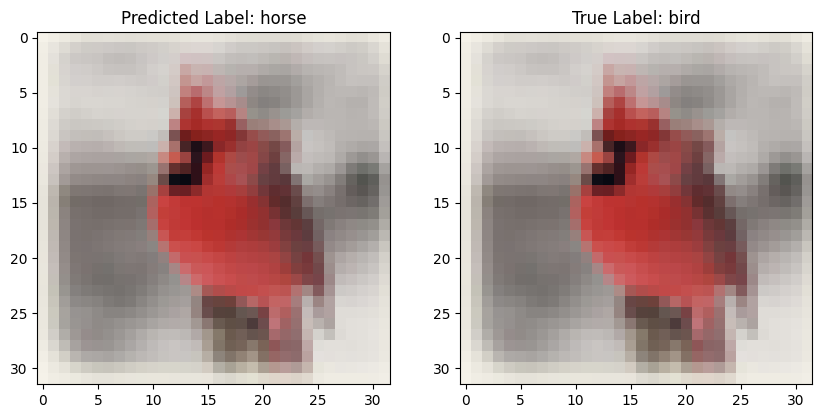

In [ ]:
def visualize_prection(testloader, model):
    random_idx = random.randint(0, len(testloader.dataset)-1)
    sample_img, sample_label = testloader.dataset[random_idx]
    
    # Get the model prediction
    model.eval()
    with torch.no_grad():
        pred = model(sample_img.unsqueeze(0))
        print(f"pred: {pred}")
        pred_class = torch.argmax(pred)
        print(f"pred_class: {pred_class}")

    # Visualize the sample image
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(sample_img.permute(1, 2, 0))
    axs[1].imshow(sample_img.permute(1, 2, 0))
    axs[1].set_title(f"True Label: {get_name_from_index(sample_label)}")
    axs[0].set_title(f"Predicted Label: {get_name_from_index(pred_class)}")
    plt.show()

visualize_prection(testloader, model)
